<a href="https://colab.research.google.com/github/khazzan/toolwearID/blob/main/TWD_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tool Wear Detection via Static image
 

In [11]:
#@title Import packages and repository
%%capture
!pip install -q tflite-model-maker
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0
!git clone https://github.com/khazzan/toolwearID.git

import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [12]:
#@title Image Dataset
dataset_is_split = True
use_custom_dataset = True
if not use_custom_dataset:
  train_data, validation_data, test_data = object_detector.DataLoader.from_csv('wear_ml_use.csv')
label_map = {1: 'flank_wear'} 

#Splitting image directories 
train_images_dir = 'toolwearID/split-dataset/train/images'
train_annotations_dir = 'toolwearID/split-dataset/train/annotations'
val_images_dir = 'toolwearID/split-dataset/validation/images'
val_annotations_dir = 'toolwearID/split-dataset/validation/annotations'
test_images_dir = 'toolwearID/split-dataset/test/images'
test_annotations_dir = 'toolwearID/split-dataset/test/annotations'

train_data = object_detector.DataLoader.from_pascal_voc(
        train_images_dir, train_annotations_dir, label_map=label_map)
validation_data = object_detector.DataLoader.from_pascal_voc(
        val_images_dir, val_annotations_dir, label_map=label_map)
test_data = object_detector.DataLoader.from_pascal_voc(
        test_images_dir, test_annotations_dir, label_map=label_map)

In [17]:
#@title Test Images
import random
images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
filenames = os.listdir(os.path.join(images_path))
random_index = random.randint(0,len(filenames)-1)
#INPUT_IMAGE = os.path.join(images_path, filenames[random_index])
INPUT_IMAGE = os.path.join(images_path, filenames[1])

In [20]:
#@title Retrieve trained TF model
%%capture
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

!python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral
!python3 -m pip install tflite-runtime
!pip install tflite-support
import tflite_runtime.interpreter as tflite 


from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size=15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model

LABELS_FILENAME = 'toolwearID/tf-lite_model/wear-labels.txt'
TFLITE_FILENAME = 'toolwearID/tf-lite_model/efficientdet-lite-wear.tflite'

labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

In [18]:
#@title Input preperation
# Image for detection
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.4, image_scale=scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)

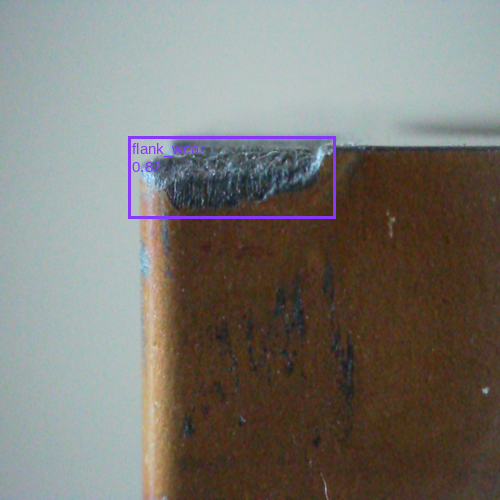

In [19]:
image